In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

## format data

In [2]:
# parameters
rand_seed = 42

div_pos = .0

n_positions = 20  # Number of unique positions
n_samples_per_pos = 1000  # Samples per position for better statistics


# Set random seeds for reproducibility
torch.manual_seed(rand_seed)
np.random.seed(rand_seed)

# Define stimulus positions
positions = np.linspace(-.39, .39, n_positions)

# Create expanded dataset with repetitions
X_repeats = np.tile(positions, n_samples_per_pos)  # Shape: (10000,)
Y_repeats = X_repeats.copy()  # Same values for Y
labels_expanded = (X_repeats > div_pos).astype(float)

# Stratified train/test split (80/20) - equal samples per position in each split
train_size_per_pos = int(0.8 * n_samples_per_pos)  # 400 samples per position for training
test_size_per_pos = int(0.2 * n_samples_per_pos)  # 100 samples per position for testing

train_indices = []
test_indices = []

for i, pos in enumerate(positions):
    # Get indices for this position
    pos_indices = np.where(X_repeats == pos)[0]
    
    # Randomly shuffle indices for this position
    pos_indices_shuffled = np.random.permutation(pos_indices)
    
    # Split for this position
    train_indices.extend(pos_indices_shuffled[:train_size_per_pos])
    test_indices.extend(pos_indices_shuffled[train_size_per_pos:])

# Convert to numpy arrays
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split data
X_train = X_repeats[train_indices]
Y_train = Y_repeats[train_indices]
labels_train = labels_expanded[train_indices]

X_test = X_repeats[test_indices]
Y_test = Y_repeats[test_indices]
labels_test = labels_expanded[test_indices]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train_tensor = torch.from_numpy(Y_train).float().unsqueeze(1)
labels_train_tensor = torch.from_numpy(labels_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1)
Y_test_tensor = torch.from_numpy(Y_test).float().unsqueeze(1)
labels_test_tensor = torch.from_numpy(labels_test).float().unsqueeze(1)

print(f"Generated {len(X_repeats)} total samples")
print(f"Training samples: {len(X_train)} ({train_size_per_pos} per position)")
print(f"Test samples: {len(X_test)} ({test_size_per_pos} per position)")
print(f"X range: [{X_repeats.min():.3f}, {X_repeats.max():.3f}]")
print(f"Unique X positions in train: {len(np.unique(X_train))}")
print(f"Unique X positions in test: {len(np.unique(X_test))}")

# Verify stratification
print("\nVerifying equal representation:")
for pos in positions[:3]:  # Check first 3 positions as example
    train_count = np.sum(X_train == pos)
    test_count = np.sum(X_test == pos)
    print(f"Position {pos:.3f}: {train_count} train, {test_count} test")

Generated 20000 total samples
Training samples: 16000 (800 per position)
Test samples: 4000 (200 per position)
X range: [-0.390, 0.390]
Unique X positions in train: 20
Unique X positions in test: 20

Verifying equal representation:
Position -0.390: 800 train, 200 test
Position -0.349: 800 train, 200 test
Position -0.308: 800 train, 200 test


## setup model

In [3]:
# Hyperparameters
divider_position = 0.0
boundary_width   = 0.05
learning_rate    = 1e-3
batch_size       = 16  # Smaller batch size for better gradient estimates
num_epochs       = 50  # Reduced epochs since we have more data


epoch_test_preds = []

# Define the multi-head model architecture
class MultiHeadModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Shared layers
        self.linear1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        
        # Separate output heads
        self.regression_head = nn.Linear(16, 1)  # For continuous output
        self.classification_head = nn.Linear(16, 1)  # For binary classification
        
    def forward(self, x):
        # Shared representation
        hidden = self.linear1(x)
        hidden = self.relu(hidden)
        
        # Separate outputs
        reg_output = self.regression_head(hidden)
        class_output = self.classification_head(hidden)
        
        return reg_output, class_output

# Create multi-head model
model = MultiHeadModel()


# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, labels_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor, labels_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer & history
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
epoch_avg_performance = {
    'train_mse': [], 'train_bce': [], 'train_total': [],
    'train_class_acc': [], 'train_reg_acc': [],
    'test_mse': [], 'test_bce': [], 'test_total': [],
    'test_class_acc': [], 'test_reg_acc': []
}

## viz noise

In [4]:
# # Visualize the position-dependent noise profile
# x_test_range = torch.linspace(-0.4, 0.4, 100).unsqueeze(1)
# with torch.no_grad():
#     noise_magnitudes = model._compute_embedding_noise_magnitude(x_test_range)

# plt.figure(figsize=(4, 2))
# plt.plot(x_test_range.squeeze(), noise_magnitudes.squeeze(), 'b-', linewidth=2)
# plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
# plt.xlabel('X Position')
# plt.ylabel('Embedding Noise Magnitude')
# plt.title('Position-Dependent Embedding Noise Profile')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.show()

# print(f"Max noise at x=0: {model.max_embedding_noise}")
# print(f"Noise at x=±0.4: {model._compute_embedding_noise_magnitude(torch.tensor([[0.4]])).item():.3f}")

## training

In [5]:
# Loss weights
mse_weight = .3
bce_weight = .7

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_mse = 0.0
    epoch_train_bce = 0.0
    epoch_train_total = 0.0
    epoch_train_class_acc = 0.0
    epoch_train_reg_acc = 0.0

    for inputs, targets, class_labels in train_loader:
        optimizer.zero_grad()
        reg_outputs, class_outputs = model(inputs)

        # Compute losses
        mse_loss = (reg_outputs - targets).pow(2).mean()
        bce_loss = F.binary_cross_entropy_with_logits(class_outputs, class_labels)
        
        # Weighted combination
        total_loss = mse_weight * mse_loss + bce_weight * bce_loss
        
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_train_mse += mse_loss.item()
        epoch_train_bce += bce_loss.item()
        epoch_train_total += total_loss.item()
        
        # Classification accuracy (using classification head)
        class_pred = torch.sigmoid(class_outputs) > 0.5
        epoch_train_class_acc += (class_pred == class_labels).float().mean().item()
        
        # Regression accuracy (within tolerance)
        reg_tolerance = 0.1
        epoch_train_reg_acc += (torch.abs(reg_outputs - targets) < reg_tolerance).float().mean().item()

    # Evaluation phase
    model.eval()
    epoch_test_mse = 0.0
    epoch_test_bce = 0.0
    epoch_test_total = 0.0
    epoch_test_class_acc = 0.0
    epoch_test_reg_acc = 0.0
    
    with torch.no_grad():
        for inputs, targets, class_labels in test_loader:
            reg_outputs, class_outputs = model(inputs)
            
            # Compute losses
            mse_loss = (reg_outputs - targets).pow(2).mean()
            bce_loss = F.binary_cross_entropy_with_logits(class_outputs, class_labels)
            
            # Weighted combination
            total_loss = mse_weight * mse_loss + bce_weight * bce_loss
            
            # Accumulate losses
            epoch_test_mse += mse_loss.item()
            epoch_test_bce += bce_loss.item()
            epoch_test_total += total_loss.item()
            
            # Classification accuracy (using classification head)
            class_pred = torch.sigmoid(class_outputs) > 0.5
            epoch_test_class_acc += (class_pred == class_labels).float().mean().item()
            
            # Regression accuracy (within tolerance)
            epoch_test_reg_acc += (torch.abs(reg_outputs - targets) < reg_tolerance).float().mean().item()
    
    # Store history
    num_train_batches = len(train_loader)
    num_test_batches = len(test_loader)
    
    epoch_avg_performance['train_mse'].append(epoch_train_mse / num_train_batches)
    epoch_avg_performance['train_bce'].append(epoch_train_bce / num_train_batches)
    epoch_avg_performance['train_total'].append(epoch_train_total / num_train_batches)
    epoch_avg_performance['train_class_acc'].append(epoch_train_class_acc / num_train_batches)
    epoch_avg_performance['train_reg_acc'].append(epoch_train_reg_acc / num_train_batches)
    
    epoch_avg_performance['test_mse'].append(epoch_test_mse / num_test_batches)
    epoch_avg_performance['test_bce'].append(epoch_test_bce / num_test_batches)
    epoch_avg_performance['test_total'].append(epoch_test_total / num_test_batches)
    epoch_avg_performance['test_class_acc'].append(epoch_test_class_acc / num_test_batches)
    epoch_avg_performance['test_reg_acc'].append(epoch_test_reg_acc / num_test_batches)
    
    # Store test predictions every epoch
    model.eval()
    with torch.no_grad():
        reg_outputs, class_outputs = model(X_test_tensor)
        epoch_test_preds.append({
            'epoch': epoch,
            'X_test': X_test.copy(),
            'Y_test': Y_test.copy(),
            'Y_pred_reg': reg_outputs.squeeze().numpy().copy(),
            'Y_pred_class': torch.sigmoid(class_outputs).squeeze().numpy().copy(),
            'labels_test': labels_test.copy()
        })

print(f"Training completed. Collected {len(epoch_test_preds)} test prediction snapshots.")

Training completed. Collected 50 test prediction snapshots.


## performance

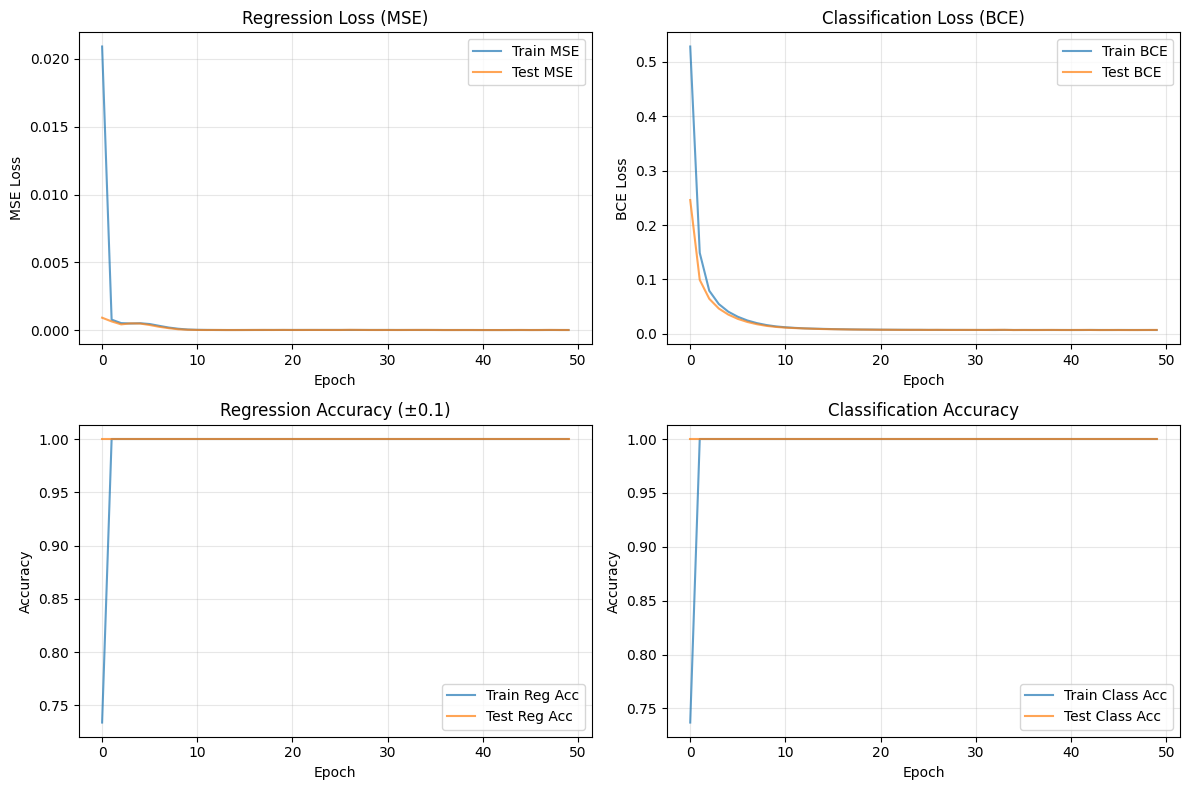

Final train MSE: 0.0000
Final test MSE: 0.0000
Final train BCE: 0.0071
Final test BCE: 0.0073
Final train reg acc: 1.000
Final test reg acc: 1.000
Final train class acc: 1.000
Final test class acc: 1.000


In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# Plot 1: Regression Loss (MSE)
axs[0].plot(epoch_avg_performance['train_mse'], label='Train MSE', alpha=0.7)
axs[0].plot(epoch_avg_performance['test_mse'], label='Test MSE', alpha=0.7)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE Loss')
axs[0].set_title('Regression Loss (MSE)')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Classification Loss (BCE)
axs[1].plot(epoch_avg_performance['train_bce'], label='Train BCE', alpha=0.7)
axs[1].plot(epoch_avg_performance['test_bce'], label='Test BCE', alpha=0.7)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('BCE Loss')
axs[1].set_title('Classification Loss (BCE)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Plot 3: Regression Accuracy
axs[2].plot(epoch_avg_performance['train_reg_acc'], label='Train Reg Acc', alpha=0.7)
axs[2].plot(epoch_avg_performance['test_reg_acc'], label='Test Reg Acc', alpha=0.7)
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Regression Accuracy (±0.1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

# Plot 4: Classification Accuracy
axs[3].plot(epoch_avg_performance['train_class_acc'], label='Train Class Acc', alpha=0.7)
axs[3].plot(epoch_avg_performance['test_class_acc'], label='Test Class Acc', alpha=0.7)
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Accuracy')
axs[3].set_title('Classification Accuracy')
axs[3].legend()
axs[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final train MSE: {epoch_avg_performance['train_mse'][-1]:.4f}")
print(f"Final test MSE: {epoch_avg_performance['test_mse'][-1]:.4f}")
print(f"Final train BCE: {epoch_avg_performance['train_bce'][-1]:.4f}")
print(f"Final test BCE: {epoch_avg_performance['test_bce'][-1]:.4f}")
print(f"Final train reg acc: {epoch_avg_performance['train_reg_acc'][-1]:.3f}")
print(f"Final test reg acc: {epoch_avg_performance['test_reg_acc'][-1]:.3f}")
print(f"Final train class acc: {epoch_avg_performance['train_class_acc'][-1]:.3f}")
print(f"Final test class acc: {epoch_avg_performance['test_class_acc'][-1]:.3f}")

## final epoch test y_hats and y_preds

In [7]:
# Create final epoch data for detailed analysis
final_snapshot = epoch_test_preds[-1]
df_final_epoch_tests = pd.DataFrame({
    'X': final_snapshot['X_test'],
    'Y_true': final_snapshot['Y_test'],
    'Y_pred_reg': final_snapshot['Y_pred_reg'],
    'Y_pred_class': final_snapshot['Y_pred_class'],
    'class_pred': (final_snapshot['Y_pred_class'] > 0.5).astype(int),
    'class_true': final_snapshot['labels_test'].astype(int),
})

print(f"Final epoch data shape: {df_final_epoch_tests.shape}")
print(f"Test points: {len(df_final_epoch_tests)}")
print("\nSample of final epoch data:")
print(df_final_epoch_tests.head(10))

Final epoch data shape: (4000, 6)
Test points: 4000

Sample of final epoch data:
      X  Y_true  Y_pred_reg  Y_pred_class  class_pred  class_true
0 -0.39   -0.39   -0.386628  3.383864e-09           0           0
1 -0.39   -0.39   -0.386628  3.383864e-09           0           0
2 -0.39   -0.39   -0.386628  3.383864e-09           0           0
3 -0.39   -0.39   -0.386628  3.383864e-09           0           0
4 -0.39   -0.39   -0.386628  3.383864e-09           0           0
5 -0.39   -0.39   -0.386628  3.383864e-09           0           0
6 -0.39   -0.39   -0.386628  3.383864e-09           0           0
7 -0.39   -0.39   -0.386628  3.383864e-09           0           0
8 -0.39   -0.39   -0.386628  3.383864e-09           0           0
9 -0.39   -0.39   -0.386628  3.383864e-09           0           0


## viz behavior

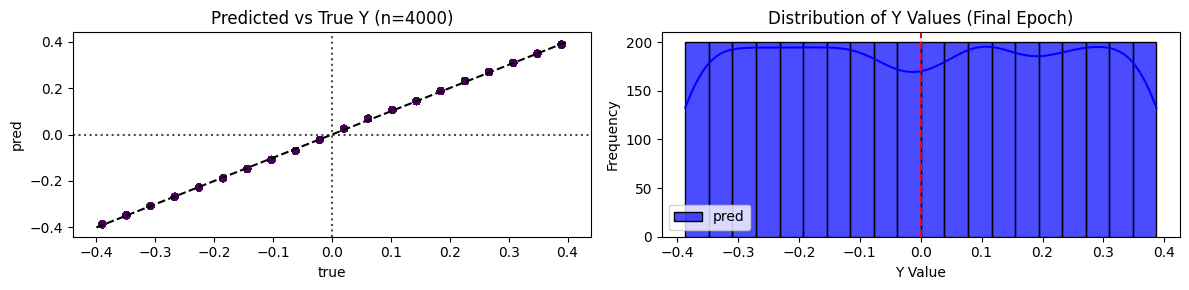

Test predictions analyzed: 4000
Regression Head Sign Classification Accuracy: 1.000
False Positive Rate: 0.000
False Negative Rate: 0.000
MSE: 0.0000
MAE: 0.0031

Classification Head Accuracy: 1.000


In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Create correctness categories based on REGRESSION outputs crossing 0
true_class_regression = (df_final_epoch_tests['Y_true'] > 0).astype(int)
pred_class_regression = (df_final_epoch_tests['Y_pred_reg'] > 0).astype(int)

# Classification performance based on regression crossing 0
correct_mask = (pred_class_regression == true_class_regression)
false_positive_mask = (pred_class_regression == 1) & (true_class_regression == 0)
false_negative_mask = (pred_class_regression == 0) & (true_class_regression == 1)

# Create color array
color_array = np.zeros(len(df_final_epoch_tests))
color_array[false_positive_mask] = 1
color_array[false_negative_mask] = 2

# Plot 1: y_pred vs y_true
sc1 = axs[0].scatter(df_final_epoch_tests['Y_true'], df_final_epoch_tests['Y_pred_reg'], 
                     c=color_array, alpha=0.6, s=20)
axs[0].plot([-0.4, 0.4], [-0.4, 0.4], 'k--')
axs[0].axvline(x=0, color='black', linestyle=':', alpha=0.7)
axs[0].axhline(y=0, color='black', linestyle=':', alpha=0.7)
axs[0].set_xlabel('true')
axs[0].set_ylabel('pred')
axs[0].set_title(f'Predicted vs True Y (n={len(df_final_epoch_tests)})')

# Plot 2: Distribution comparison
sns.histplot(df_final_epoch_tests['Y_pred_reg'], bins=20, kde=True, color='blue', 
             label='pred', ax=axs[1], alpha=0.7)
# sns.histplot(df_final_epoch_tests['Y_true'], bins=20, kde=True, color='orange', 
#              label='true', ax=axs[1], alpha=0.5)
axs[1].axvline(x=0, color='red', linestyle='--')
axs[1].set_xlabel('Y Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Y Values (Final Epoch)')
axs[1].legend()

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print(f"Test predictions analyzed: {len(df_final_epoch_tests)}")
print(f"Regression Head Sign Classification Accuracy: {correct_mask.mean():.3f}")
print(f"False Positive Rate: {false_positive_mask.mean():.3f}")
print(f"False Negative Rate: {false_negative_mask.mean():.3f}")
print(f"MSE: {((df_final_epoch_tests['Y_pred_reg'] - df_final_epoch_tests['Y_true'])**2).mean():.4f}")
print(f"MAE: {abs(df_final_epoch_tests['Y_pred_reg'] - df_final_epoch_tests['Y_true']).mean():.4f}")

# Additional stats for classification head
class_correct_mask = (df_final_epoch_tests['class_pred'] == df_final_epoch_tests['class_true'])
print(f"\nClassification Head Accuracy: {class_correct_mask.mean():.3f}")

## viz embeddings

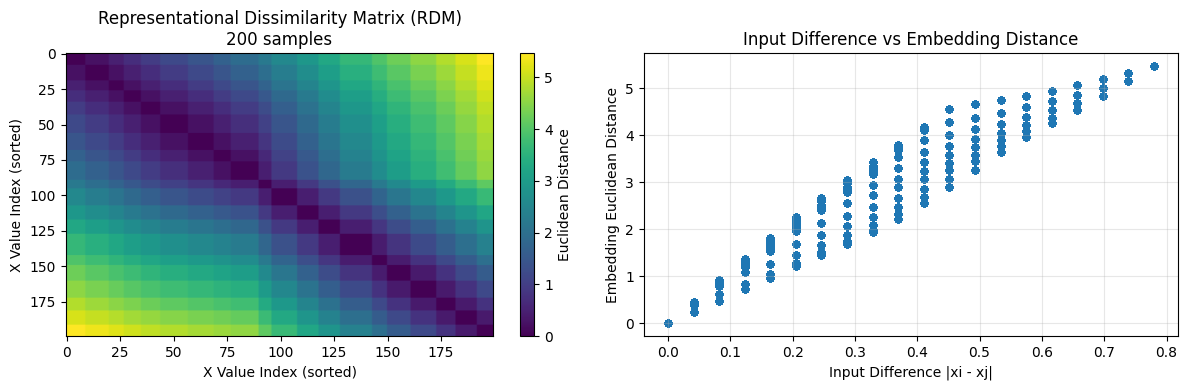

Embedding samples analyzed: 200
Embedding shape: (200, 16)
RDM shape: (200, 200)
Input range: [-0.390, 0.390]
Input difference range: [0.000, 0.780]
Embedding distance range: [0.000, 5.470]
Correlation between input and embedding distances: 0.962


In [9]:
# Extract embeddings from the hidden layer
def get_embeddings(model, x_vals):
    """Extract hidden layer representations (embeddings) from the model."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for x in x_vals:
            x_tensor = torch.tensor([[x]], dtype=torch.float32)
            
            # Get output from first layer
            hidden = model.linear1(x_tensor)  # First linear layer
            hidden = model.relu(hidden)       # ReLU activation
            
            embeddings.append(hidden.squeeze().numpy())
    
    return np.array(embeddings)

# Use a subset of the test data for embedding analysis
# Sample from the actual test set we have
n_embedding_samples = min(200, len(X_test))  # Use up to 200 samples
embedding_indices = np.random.choice(len(X_test), size=n_embedding_samples, replace=False)
x_embedding_test = X_test[embedding_indices]
x_embedding_test = np.sort(x_embedding_test)  # Sort for visualization

# Get embeddings for these X values
embeddings = get_embeddings(model, x_embedding_test)

# Compute pairwise Euclidean distances (RDM)
from scipy.spatial.distance import pdist, squareform
distances = pdist(embeddings, metric='euclidean')
rdm = squareform(distances)

# Compute input differences for scatter plot
input_diffs = []
embed_dists = []
for i in range(len(x_embedding_test)):
    for j in range(i+1, len(x_embedding_test)):
        input_diffs.append(abs(x_embedding_test[i] - x_embedding_test[j]))
        embed_dists.append(rdm[i, j])

# Plot the RDM and additional analysis
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# RDM heatmap
im = axs[0].imshow(rdm, cmap='viridis', aspect='auto')
axs[0].set_title(f'Representational Dissimilarity Matrix (RDM)\n{n_embedding_samples} samples')
axs[0].set_xlabel('X Value Index (sorted)')
axs[0].set_ylabel('X Value Index (sorted)')
fig.colorbar(im, ax=axs[0], label='Euclidean Distance')

# Plot input difference vs embedding distance
axs[1].scatter(input_diffs, embed_dists, alpha=0.6, s=20)
axs[1].set_xlabel('Input Difference |xi - xj|')
axs[1].set_ylabel('Embedding Euclidean Distance')
axs[1].set_title('Input Difference vs Embedding Distance')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Embedding samples analyzed: {n_embedding_samples}")
print(f"Embedding shape: {embeddings.shape}")
print(f"RDM shape: {rdm.shape}")
print(f"Input range: [{x_embedding_test.min():.3f}, {x_embedding_test.max():.3f}]")
print(f"Input difference range: [{min(input_diffs):.3f}, {max(input_diffs):.3f}]")
print(f"Embedding distance range: [{min(embed_dists):.3f}, {max(embed_dists):.3f}]")

# Additional analysis: correlation between input and embedding distances
correlation = np.corrcoef(input_diffs, embed_dists)[0, 1]
print(f"Correlation between input and embedding distances: {correlation:.3f}")